# Deep Learning Exam:

## Part I : Modeling and solving partial differential equations using neural layers.

---

The numerical methods and neural networks are in two different domains and we rarely see them combined. However, solving a PDE using differentiable operations (operations that can be back-propagated through) is a very interesting and promising approach toward a more hybrid approaches integrating PDE into deep learning. In this exam, you will be required to model and solve a partial differential equation using neural layers.
## Instructions:
- You are required to complete the code cells and provide explanations where necessary.
- Ensure that your code is well-documented and organized.
- After completing the exam, save this notebook and submit it for evaluation.

---

### Task 1: Modeling the Advection equation
In this task, the convolution operation can be used to compute the spatial derivatives of a function, by convolving the function with a kernel that contains the finite difference coefficients. The `AdvectionCentralDiff` class provided below models the advection equation using central difference scheme.
#### Question:
- Complete the `AdvectionCentralDiff` class provided below modeling the advection equation using central difference scheme.
$$\frac{\partial f}{\partial t} + V\cdot \nabla f = 0$$
where \(V\) is the velocity (field or scalar), \(f\) is the function to be solved, and $V\cdot \nabla f = V_x \frac{\partial f}{\partial x} + V_y \frac{\partial f}{\partial y}$.
- For the x-axis, use the the following kernel:
$$\begin{bmatrix}
0 & a & 0\\
0 & b & 0\\
0 & c & 0
\end{bmatrix}$$
where $a, b, c$ are the finite difference coefficients.
- For the y-axis, use the the following kernel:
$$\begin{bmatrix}
0 & 0 & 0\\
a & b & c\\
0 & 0 & 0
\end{bmatrix}$$
where $a, b, c$ are the finite difference coefficients.

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvectionCentralDiff(nn.Module):
    """
    A class to represent the finite difference method for solving the advection equation.

    Attributes:
        dx (tuple): Grid spacing in x and y directions.
    """

    def __init__(self, dx: tuple = (1. / 256, 1. / 256)):
        super().__init__()
        self.dx = dx[0]
        self.dy = dx[1]
        # Padding
        self.pad = {'pad': (1, 1, 1, 1), 'mode': "replicate"}
        # Central difference kernel, check the documentation for the correct shape
        self.kernel_Dc_x1 = torch.tensor([[0,-1/(2*self.dx), 0],[0,0,0],[0,1/(2*self.dx),0]]).repeat(1,1,1,1)
        self.kernel_Dc_y1 = torch.tensor([[0, 0, 0],[-1/(2*self.dy), 0, 1/(2*self.dy)],[0,0,0]]).repeat(1,1,1,1)
        self.bias = torch.Tensor([0.])
        print(self.kernel_Dc_x1)

    def set_device(self, device: str or int):
        """
        Set GPU ID.

        Args:
            device (str or int): GPU id, e.g. 'cuda:0', 'cuda:1', etc. or 'cpu'
        """
        self.device = device
        self.bias = self.bias.to(device)
        self.kernel_Dc_x1 = self.kernel_Dc_x1.to(device)
        self.kernel_Dc_y1 = self.kernel_Dc_y1.to(device)


    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward method.

        Args:
            inputs (torch.Tensor): Inputs equation variables.

        Returns:
            torch.Tensor: Trend tensor.
        """
        f, u, v= inputs[0],inputs[1],inputs[2]

        # Apply padding using pad function to maintain the size of the input tensor
        padded_f = F.pad(f, pad = (2,2))

        # Apply the central difference kernel to the input tensor
        Dc_x_o1 = F.conv2d(padded_f, self.kernel_Dc_x1, padding = (1, 1))
        Dc_y_o1 = F.conv2d(padded_f, self.kernel_Dc_y1, padding = (1,1))

        # trend represents the time derivative of the input variable
        trend = - u*Dc_x_o1 - v*Dc_y_o1
        return trend

### Task 2: Implementing the time integration scheme

#### Question:
- Complete the `RungeKutta4` class provided below. The class should implement the fourth-order Runge-Kutta method for solving ordinary differential equations.

In [135]:
class RungeKutta4(nn.Module):
    """
    PyTorch module implementing the 4th order Runge-Kutta (RK4) scheme for solving the advection equation.

    Args:
        trend (module): A Model that takes as inputs tensors representing the temperature field at time t
            and returns a tensor representing the trend at time t.
        dt (float): The time step size.
    """

    def __init__(self, trend: nn.Module, dt=1):
        super().__init__()
        self.trend = trend
        self.dt = dt



    def forward(self, inputs) -> torch.Tensor:
        """
        Computes one step of the 4th order Runge-Kutta scheme.

        Args:
            inputs (torch.Tensor): Temperature field at time t.

        Returns:
            torch.Tensor: The temperature field at time t + dt.
        """

        f, u, v= inputs[0],inputs[1],inputs[2]

        # trend represents the time derivative of the input variable
        k1 = self.trend(f, u, v)
        k2 = self.trend(f + self.dt*0.5*k1, u, v)
        k3 = self.trend(f + self.dt*0.5*k2, u, v)
        k4 = self.trend(f + self.dt*k3, u, v)

        return f + (k1+k2*2+k3*2+k4)*(self.dt/6)

### Task 3: Solving the advection equation using the implemented classes

#### Question:
1. Instantiate an object of the `AdvectionCentralDiff` class.
2. Instantiate an object of the `RungeKutta4` class, passing the `AdvectionCentralDiff` object as a parameter.
3. Make sure that the time step verifies the CFL condition.
4. Perform 100 iterations of the time integration scheme.

You can play with the parameters and initial conditions to see how the solution behaves.

In [142]:

import numpy as np
# Set the device (e.g., GPU or CPU)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Setting grid parameters
h = 256
l = 256
dx, dy = 1/h, 1/l
X = torch.linspace(-1, 1, h)
Y = torch.linspace(-1, 1, l)
x, y = torch.meshgrid(X, Y)
# Initial condition
c_initial = torch.exp(-10 * (x ** 2 + y ** 2)).unsqueeze(0).unsqueeze(0).to(device)
# Advection velocity
u = dx*20*torch.ones((h,l)).unsqueeze(0).unsqueeze(0).to(device)
v = dy*15*torch.ones((h,l)).unsqueeze(0).unsqueeze(0).to(device)
# Time step
CFL = (u.max())/dx
dt = 0.2/CFL
print('time step:', dt)

pde = AdvectionCentralDiff(dx = (dx, dy))
rk4_solver = RungeKutta4(pde, dt=dt)

# Set the device (e.g., GPU or CPU)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
pde.set_device(device)
rk4_solver.to(device)

print(c_initial.squeeze().size())

niters = 100
# Perform RK4 integration for multiple steps
list_res = [c_initial]
for _ in range(niters - 1):
    result = rk4_solver([list_res[-1], u, v])
    list_res.append(result)
list_res = torch.cat(list_res).cpu().detach().numpy()
print(list_res.shape)


time step: tensor(0.0100)
tensor([[[[   0., -128.,    0.],
          [   0.,    0.,    0.],
          [   0.,  128.,    0.]]]])
torch.Size([256, 256])


TypeError: AdvectionCentralDiff.forward() takes 2 positional arguments but 4 were given

TypeError: list indices must be integers or slices, not tuple

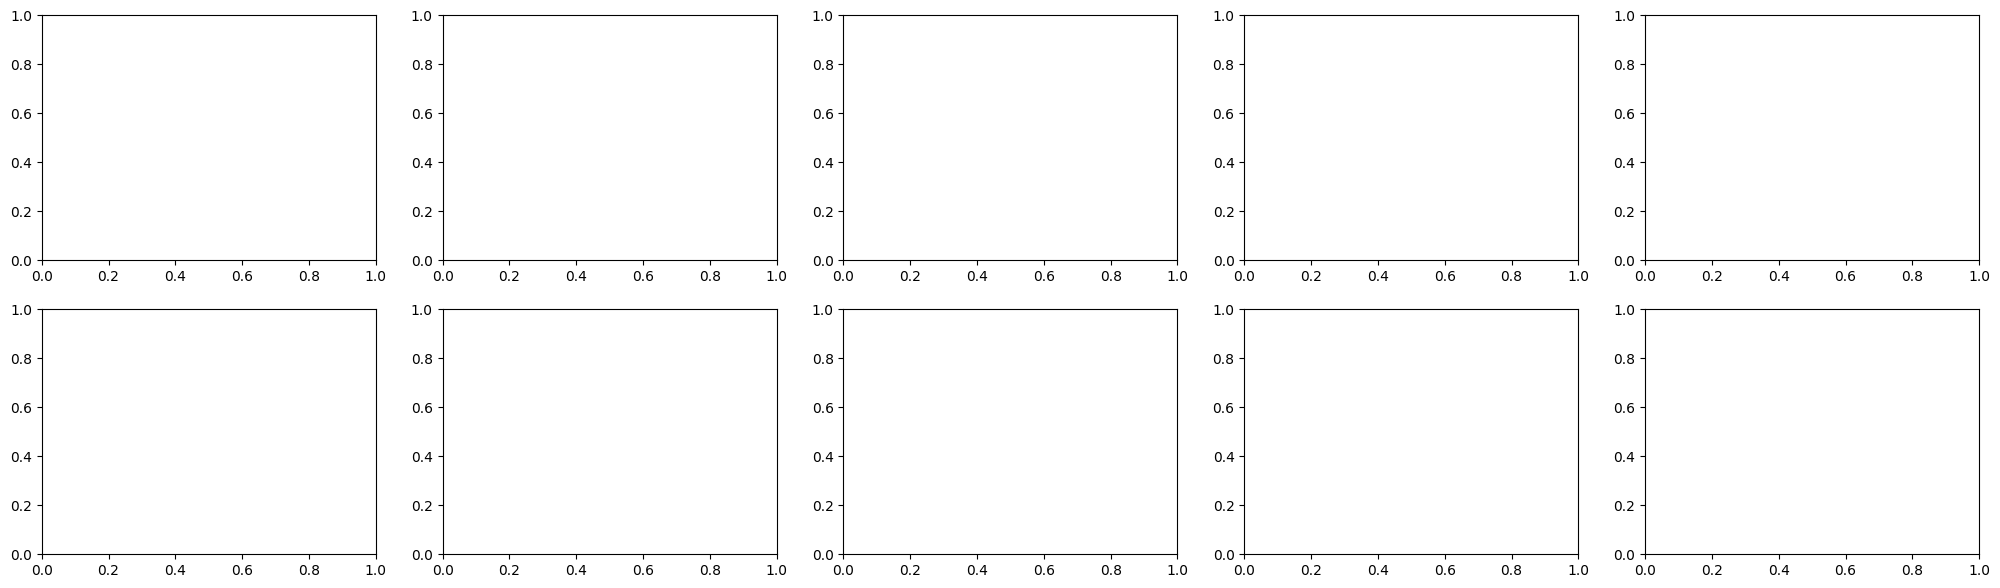

In [84]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(2,5,figsize=(25,7))
axes=axes.flatten()
step = 10
for i in range(10):
    im = axes[i].imshow(list_res[step * i, 0, :, :],origin='lower')
    axes[i].set_title(f"t={step * i}")
    plt.colorbar(im, ax=axes[i])
plt.grid(False)
plt.show()

### Task 4: Modeling the Advection-Diffusion equation
#### Question:
- Implement the `AdvectionDiffusionCentralDiff` class, which models the next advection-diffusion equation using central difference scheme.
$$\frac{\partial f}{\partial t} + V\cdot \nabla f = D\cdot \nabla^2 f$$
where \(V\) is the velocity (field or scalar), \(D\) is the diffusion coefficient, and \(f\) is the function to be solved.
where \(D\) is the diffusion coefficient. The \(D\) should be given as input along with the velocity \(V\).

In [ ]:
class AdvectionDiffusionCentralDiff(nn.Module):
    ...

### Task 5: Solving the advection-diffusion equation using the implemented classes
#### Question:
1. Instantiate an object of the `AdvectionDiffusionCentralDiff` class.
2. Instantiate an object of the `RungeKutta4` class, passing the `AdvectionDiffusionCentralDiff` object as a parameter.
3. Make sure that the time step verifies the CFL condition.
4. The diffusion coefficient \(D\) should verify, $D \leq \frac{\Delta x^2}{2\Delta t}$.
5. Perform 100 iterations of the time integration scheme.
6. Check that you get an advection equation when \(D = 0\).

Note: Don't worry if the solution diverges, it's not the goal of this exam !